In [1]:
import copy
from matplotlib import pyplot as plt
import numpy as np
import sea2025
from part2_opf_helpers import clear_market, postprocess, make_graph, plot_graph

Worksheet 2: Optimal power flow on general networks
===================================================

# Objective

We'll extend the LP formulation of worksheet 1 for general networks.

# Examine input data

This is the same format as before, with a most interesting network comprised of 5 buses and 6 lines.

(This particular dataset originated at PJM and is described [here](https://doi.org/10.1109/PES.2010.5589973).)

As we did in the last worksheet, briefly examine the tables comprising `data`: Add a new `Code` cell for each field.

In [2]:
data = sea2025.data.read("data/pjm5bus")

# Solve the OPF problem using an existing function

Let's start with an existing routine and visualize the resulting solution: We'll then walk through the underlying formulation.

In [3]:
result = clear_market(data)
print(f"Optimal dispatch cost: ${result.total_cost:.2f}/h")

Optimal dispatch cost: $17479.90/h


We have an existing routine to visualize the solution: Optimal dispatch, line flows, and locational marginal prices.

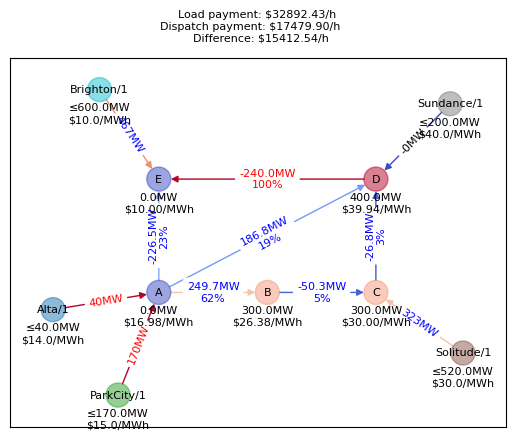

In [4]:
postprocess(result)
graph = make_graph(result)
plot_graph(graph, kscale=1.0, xscale=1.0, yscale=1.0)
plt.savefig("images/pjm6bus.png")

## Verify feasibility of line flows

If the computed line flows are feasible, they must satisfy:
* Balance constraint: Edge flows at each bus is zero
* Power flow constraint: Line flows correspond to differences in (single-valued) bus voltage angles, which should sum to zero around any loop.

Let's check these properties, using the solution attributes now embedded in `graph`.

In [5]:
bus_flows = sea2025.verification.bus_residuals(graph)
print(bus_flows)

   bus   adjacency        flow
0    A      Alta/1   40.000000
1    A  ParkCity/1  170.000000
2    A           B -249.716765
3    A           D -186.788389
4    A           E  226.505154
5    A           A   -0.000000
6    B           A  249.716765
7    B           C   50.283235
8    B           B -300.000000
9    C           B  -50.283235
10   C  Solitude/1  323.494846
11   C           D   26.788389
12   C           C -300.000000
13   D           A  186.788389
14   D           C  -26.788389
15   D  Sundance/1   -0.000000
16   D           E  240.000000
17   D           D -400.000000
18   E           A -226.505154
19   E           D -240.000000
20   E  Brighton/1  466.505154
21   E           E   -0.000000


Aggregating these, we get the residual in each balance constraint:

In [6]:
print(bus_flows.groupby("bus").agg("sum"))

                adjacency          flow
bus                                    
A    Alta/1ParkCity/1BDEA  1.421085e-13
B                     ACB  0.000000e+00
C           BSolitude/1DC  0.000000e+00
D          ACSundance/1ED  0.000000e+00
E           ADBrighton/1E  0.000000e+00


In [7]:
cycle_edges = sea2025.verification.cycle_edges(graph)
print(cycle_edges)

     name from to        flow  reactance  delta_angle
0    ABCD    A  B  249.716765       2.81     7.017041
1    ABCD    B  C  -50.283235       1.08    -0.543059
2    ABCD    C  D  -26.788389       2.97    -0.795615
3    ABCD    A  D  186.788389       3.04    -5.678367
4   ABCDE    A  B  249.716765       2.81     7.017041
5   ABCDE    B  C  -50.283235       1.08    -0.543059
6   ABCDE    C  D  -26.788389       2.97    -0.795615
7   ABCDE    D  E -240.000000       2.97    -7.128000
8   ABCDE    A  E -226.505154       0.64     1.449633
9     DAE    A  D  186.788389       3.04    -5.678367
10    DAE    A  E -226.505154       0.64    -1.449633
11    DAE    D  E -240.000000       2.97     7.128000


In [8]:
print(cycle_edges.groupby("name").agg({"delta_angle": "sum"}))

        delta_angle
name               
ABCD  -8.881784e-16
ABCDE -1.110223e-15
DAE    0.000000e+00


# Check marginal costs

We met marginal cost as the cost increment associated with a unit increment in load. Let's verify this property.

In [9]:
def cost_delta(bus_index: int) -> float:
    global data, result
    data_perturbed = copy.deepcopy(data)
    data_perturbed.buses.at[bus_index, "load"] += 1.0
    result_perturbed = clear_market(data_perturbed)
    return result_perturbed.total_cost - result.total_cost


cost_deltas = [cost_delta(i) for i in data.buses.index]
print(cost_deltas)
assert np.allclose(result.buses["price"], cost_deltas)

[np.float64(16.97735882300549), np.float64(26.384459518980293), np.float64(30.0), np.float64(39.94273632278782), np.float64(10.0)]


# Inside the formulation

Having checked that out computed solution is plausible, let's try to reproduce it.

The incomplete solution below is close to the "single-bus" LP formulation. Try to add the missing parts (marked `TODO`).

The incidence matrices below are helpful (although you might prefer to work directly with the data tables).

In [10]:
buses = data.buses
generators = data.generators
lines = data.lines
offers = data.offers.copy()  # copy for update
reference_bus = data.reference_bus
base_power = data.base_power
reference_bus_index = sea2025.incidence.reference_bus(buses, reference_bus)

line_bus = sea2025.incidence.line_bus(buses=buses, lines=lines)
offer_bus = sea2025.incidence.offer_bus(offers=offers, buses=buses, generators=generators)

Compare each incidence matrix with the plot to understand what it refers to.

In [11]:
print(line_bus.shape)
line_bus  # line-bus incidence matrix

(6, 5)


array([[-1,  1,  0,  0,  0],
       [-1,  0,  0,  1,  0],
       [-1,  0,  0,  0,  1],
       [ 0, -1,  1,  0,  0],
       [ 0,  0, -1,  1,  0],
       [ 0,  0,  0, -1,  1]], dtype=int8)

Note that every row ("line") has one `-1` and one `+1`, corresponding to the tail and the head of the edge.

In [12]:
print(offer_bus.shape)
offer_bus   # offer-bus incidence matrix

(5, 5)


array([[ True, False, False, False, False],
       [ True, False, False, False, False],
       [False, False,  True, False, False],
       [False, False, False,  True, False],
       [False, False, False, False,  True]])

In [13]:
import cvxpy as cp

# Decision variables
p = cp.Variable(offers.index.size, name="p")  # dispatched/injected power [MW]
f = cp.Variable(lines.index.size, name="f")  # line flows [MW]
θ = cp.Variable(buses.index.size, name="θ")  # bus angles [rad]  # TODO 1: Missing variabls

# Equality constraints on buses and lines
balance_constraints = [
    cp.sum([p[o] * offer_bus[o, b] for o in offers.index])
    + cp.sum([f[ell] * line_bus[ell, b] for ell in lines.index]) # TODO 2: Missing flow terms
    == buses.at[b, "load"]
    for b in buses.index
]
flow_constraints = [
    f[ell]
    == cp.sum([line_bus[ell, b] * θ[b] for b in buses.index])
    * base_power
    / lines.at[ell, "reactance"]
    for ell in lines.index
]

objective = cp.Minimize(cp.sum([offers.at[o, "price"] * p[o] for o in offers.index]))
problem = cp.Problem(
    objective,
    [
        *balance_constraints,
        *flow_constraints,
        θ[reference_bus_index] == 0,
        f >= -lines["capacity"],  # TODO 3: Lower bound for line flow f
        f <= lines["capacity"],
        p >= 0,
        p <= offers["quantity"],  # TODO 4: Upper bound for offer injection
    ],
)
problem.solve(solver=cp.HIGHS)
assert problem.status == cp.OPTIMAL, f"Solver failed: {problem.status}"

total_cost = problem.value
dispatch = p.value
flow = f.value
angle = θ.value
marginal_price = [-c.dual_value for c in balance_constraints]

Verify that our solution is consistent with the earlier one that we've already checked!

In [14]:
assert np.allclose(dispatch, result.offers["dispatch"].values)
assert np.allclose(flow, result.lines["flow"].values)
assert np.allclose(angle, result.buses["angle"].values)
assert np.allclose(marginal_price, result.buses["price"].values)
assert np.isclose(total_cost, result.total_cost)

# Interpretation of the solution

With your neighbour, try to find analogies between the solution plot of this 5-bus network and the offer stack of the preceding worksheet.
* Which offer/s are marginal?
* Which offers are fully dispatched?
* Which LMPs correspond directly to offer prices? Which do not?
* What is the impact of the congested line?

Don't worry if you don't make progress: We'll continue with this theme on a simpler network in tne next worksheet.

The solution is reproduced here for convenience.

![](images/pjm6bus-v1.png)

